In [13]:
from os import path, makedirs, walk,listdir, remove
import pandas as pd
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Rescaling
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory, split_dataset
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, TrueNegatives, TruePositives, FalseNegatives, FalsePositives
from keras.callbacks import EarlyStopping
from random import choice

In [2]:
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = 'dataset'
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')

#Hyperparameters
OPTIMIZER = Adam
LEARNING_RATE = 0.0001
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), F1Score(name='f1'), TrueNegatives(name='tn'), TruePositives(name='tp'), FalseNegatives(name='fn'), FalsePositives(name='fp')]
EPOCHS = 50
BATCH_SIZE = 10
VERBOSE = 1
REGULARIZER=None
VALIDATION_SPLIT = 0.2
INPUT_SHAPE = (256,256,1)

2024-03-26 09:32:29.528814: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-26 09:32:29.528838: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-26 09:32:29.528843: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-26 09:32:29.529100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-26 09:32:29.529122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#remove any non-jpg files in the directories
def find_and_remove_non_jpg_files(a_folder_path):
    #removes any non-jpg files in the provided directory
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = path.join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [4]:
#remove any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        folder_path = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name,class_dir_name)
        print('checking folder: '+folder_path)
        find_and_remove_non_jpg_files(folder_path)
        folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: dataset/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_no_fracture
Deleted 0 files.
checked 6 folders


In [6]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory= path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [7]:
#Load the images into datasets
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')
print('train_ds', train_ds.cardinality())
print('test_ds', test_ds.cardinality())
print('valid_ds', valid_ds.cardinality())

#create a combined dataset so the data can be shuffled and then split into training and test sets
combined_ds = train_ds.concatenate(valid_ds).concatenate(test_ds)
print('combined_ds', combined_ds.cardinality())

Found 3630 files belonging to 2 classes.
Found 169 files belonging to 2 classes.
Found 348 files belonging to 2 classes.
train_ds tf.Tensor(363, shape=(), dtype=int64)
test_ds tf.Tensor(17, shape=(), dtype=int64)
valid_ds tf.Tensor(35, shape=(), dtype=int64)
combined_ds tf.Tensor(415, shape=(), dtype=int64)


In [8]:
combined_images = []
combined_labels = []
for images, labels in combined_ds.as_numpy_iterator():
    combined_images.extend(images)
    combined_labels.extend(labels)
combined_images = np.array(combined_images)
combined_labels = np.array(combined_labels)

X_train, X_test, y_train, y_test = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

2024-03-26 09:34:36.593272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train (3317, 256, 256, 1)
X_test (830, 256, 256, 1)
y_train (3317, 1)
y_test (830, 1)


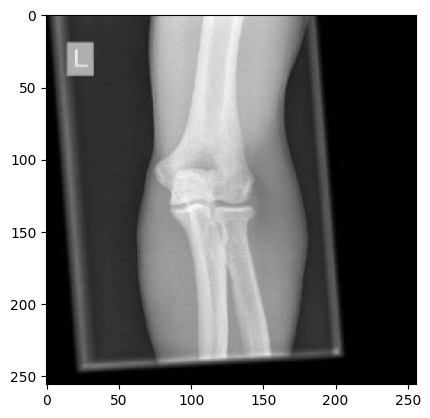

In [9]:
random_training_image = choice(X_train)
plt.imshow(random_training_image, cmap='gray')
plt.show()

In [10]:
def create_model(input_shape):

    #create a Sequential  model
    model = Sequential()
    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #Flatten the output so that it can be processed as a Vector by the subsequent Dense layer
    model.add(Flatten())

    #add a fully connected layer with  64 neurons and a relu activation function outut shape = 64
    model.add(Dense(256, kernel_regularizer=REGULARIZER, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [11]:
model = create_model(INPUT_SHAPE)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,352,577 (226.41 MB)

 Trainable params: 59,352,577 (226.41 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def train_model(X_train, y_train):
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, verbose=VERBOSE, restore_best_weights=True)]
    
    model = create_model(INPUT_SHAPE)
    model.compile(optimizer=OPTIMIZER(LEARNING_RATE), loss=LOSS_FUNCTION(), metrics=METRICS)
    model_history = model.fit(
                            X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_split=VALIDATION_SPLIT,
                            verbose=VERBOSE,
                            callbacks=callbacks)
    clear_session()

    return (model, model_history)

In [16]:
model, model_history = train_model(X_train, y_train)

Epoch 1/50


2024-03-26 09:37:46.076316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


266/266 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.4908 - f1: 0.6714 - fn: 168.6517 - fp: 493.6068 - loss: 0.6991 - precision: 0.4974 - recall: 0.7394 - tn: 174.2622 - tp: 503.3895 - val_accuracy: 0.5934 - val_f1: 0.6942 - val_fn: 84.0000 - val_fp: 186.0000 - val_loss: 0.6818 - val_precision: 0.5912 - val_recall: 0.7620 - val_tn: 125.0000 - val_tp: 269.0000
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 114ms/step - accuracy: 0.5969 - f1: 0.6731 - fn: 221.3633 - fp: 319.6891 - loss: 0.6625 - precision: 0.5853 - recall: 0.7028 - tn: 348.8277 - tp: 450.0300 - val_accuracy: 0.6386 - val_f1: 0.6942 - val_fn: 105.0000 - val_fp: 135.0000 - val_loss: 0.6452 - val_precision: 0.6475 - val_recall: 0.7025 - val_tn: 176.0000 - val_tp: 248.0000
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 114ms/step - accuracy: 0.6991 - f1: 0.6648 - fn: 193.6517 - fp: 209.1161 - loss: 0.5748 - precision: 0.6889 - recall: 0.7236 - tn: 462.6891 - tp: 474.4532 - val_accuracy: 0.6310 - val_f1: 0.6942 - val_fn: 114.0

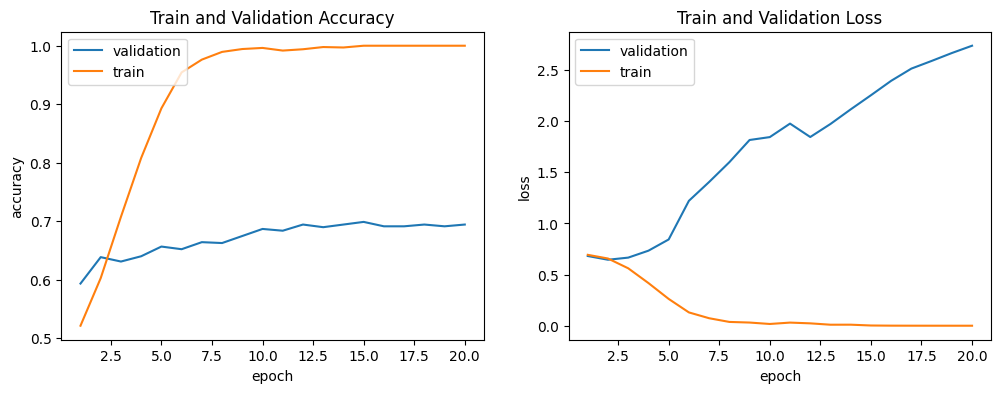

In [17]:
#plot the model accuracy and lo ss]
epochs = len(model_history.history['accuracy'])
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, epochs+1), valid_accuracy) 
accuracy.plot(range(1, epochs+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, epochs+1), valid_loss)
loss.plot(range(1, epochs+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()

In [18]:
results  = model.evaluate(X_test, y_test)
print('accuracy', results[1])
print('loss', results[0])
print('precision', results[2])
print('recall', results[3])
print('f1', results[4])
print('tn', results[5])
print('tp', results[6])
print('fn', results[7])
print('fp', results[8])

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6885 - f1: 0.6867 - fn: 69.6296 - fp: 73.5185 - loss: 1.9843 - precision: 0.6907 - recall: 0.7043 - tn: 150.5926 - tp: 152.9259
accuracy 0.6710843443870544
loss 2.373782157897949
precision 0.669958770275116
recall 138.0
f1 135.0
tn 0.6707317233085632
tp 0.665859580039978
fn 282.0
fp 275.0


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step


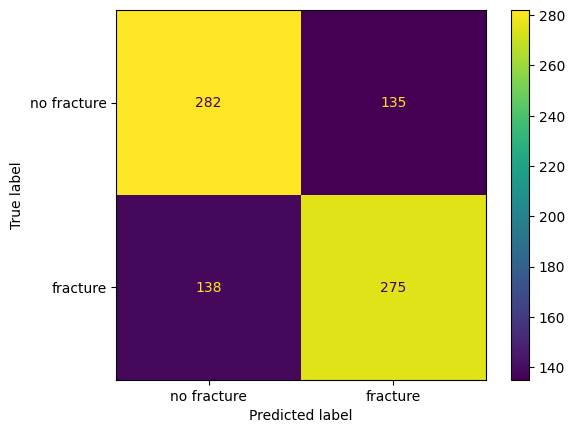

In [19]:
predictions = model.predict(X_test)
binary_predictions = np.where(predictions > 0.5, 1, 0)
binary_predictions
matrix = confusion_matrix(y_test, binary_predictions)
ConfusionMatrixDisplay(matrix, display_labels=['no fracture', 'fracture']).plot()

In [20]:
import datetime
print("Last modified: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")

Last modified:  26/03/2024 09:49:29
